# Klasifikasi Kanker Paru (Faktor Risiko)

Program sesuai proposal: Logistic Regression vs XGBoost, penanganan imbalance (class weight & SMOTE), evaluasi (F1-score, confusion matrix), serta visualisasi.

## 1. Setup & Import

In [4]:
import os, json, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

from xgboost import XGBClassifier

try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMBLEARN_AVAILABLE = True
except Exception:
    IMBLEARN_AVAILABLE = False


## 2. Konfigurasi & Load Data

In [5]:
RANDOM_STATE = 42
TEST_SIZE = 0.20
THRESHOLD = 0.50

FEATURES = [
    "GENDER","AGE","SMOKING","YELLOW_FINGERS","ANXIETY","PEER_PRESSURE","CHRONIC_DISEASE",
    "FATIGUE","ALLERGY","WHEEZING","ALCOHOL_CONSUMING","COUGHING","SHORTNESS_OF_BREATH",
    "SWALLOWING_DIFFICULTY","CHEST_PAIN"
]
TARGET = "LUNG_CANCER"

XGB_PARAMS = dict(
    n_estimators=400, max_depth=4, learning_rate=0.05,
    subsample=0.9, colsample_bytree=0.9,
    reg_lambda=1.0, min_child_weight=1,
    objective="binary:logistic", eval_metric="logloss",
    random_state=RANDOM_STATE, n_jobs=-1
)

DATA_PATH_CANDIDATES = [
    "lcs_clean.csv",
    os.path.join(os.getcwd(), "lcs_clean.csv"),
    "/mnt/data/lcs_clean.csv",
]
DATA_PATH = next((p for p in DATA_PATH_CANDIDATES if os.path.exists(p)), None)
if DATA_PATH is None:
    raise FileNotFoundError("Tidak menemukan lcs_clean.csv")
print("DATA_PATH =", DATA_PATH)

df = pd.read_csv(DATA_PATH)
df.head()


DATA_PATH = lcs_clean.csv


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC_DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL_CONSUMING,COUGHING,SHORTNESS_OF_BREATH,SWALLOWING_DIFFICULTY,CHEST_PAIN,LUNG_CANCER
0,1,69,1,0,0,1,0,1,0,0,1,1,1,0,0,1
1,1,71,1,1,0,0,1,0,1,1,0,0,1,1,0,1
2,1,61,1,0,0,1,1,0,1,1,0,0,1,1,1,0
3,1,55,1,1,0,1,0,0,0,1,1,0,1,1,1,1
4,0,56,1,0,0,0,0,1,1,1,1,0,1,1,1,1


## 3. Analisis Awal & Visualisasi

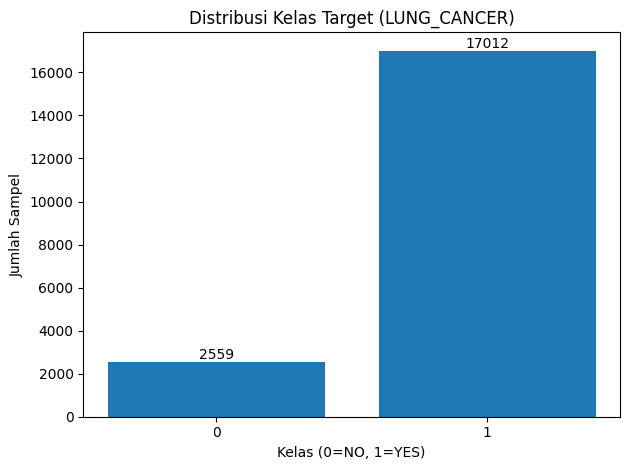

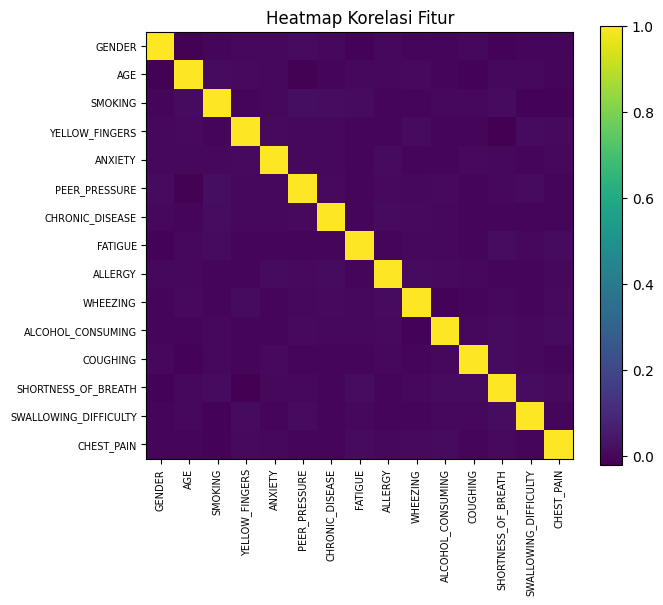

In [6]:
y = df[TARGET].astype(int)
X = df[FEATURES].copy()

# Distribusi kelas
counts = y.value_counts().sort_index()
plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribusi Kelas Target (LUNG_CANCER)")
plt.xlabel("Kelas (0=NO, 1=YES)")
plt.ylabel("Jumlah Sampel")
for i, v in enumerate(counts.values):
    plt.text(i, v, str(v), ha="center", va="bottom")
plt.tight_layout()
plt.show()

# Heatmap korelasi (matplotlib)
corr = X.corr(numeric_only=True)
plt.figure(figsize=(7,6))
plt.imshow(corr, interpolation="nearest")
plt.title("Heatmap Korelasi Fitur")
plt.colorbar()
ticks = np.arange(len(corr.columns))
plt.xticks(ticks, corr.columns, rotation=90, fontsize=7)
plt.yticks(ticks, corr.columns, fontsize=7)
plt.tight_layout()
plt.show()


## 4. Split Data (Stratified) & Class Weight

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

classes = np.array([0,1], dtype=int)
cw_values = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
cw = {int(c): float(w) for c, w in zip(classes, cw_values)}
print("Class weight:", cw)


Train: (15656, 15) Test: (3915, 15)
Class weight: {0: 3.8241328773815337, 1: 0.5752075832169887}


## 5. Model 1: Logistic Regression (class weight)

F1 (pos): 0.6487382575059863
              precision    recall  f1-score   support

           0     0.1308    0.4824    0.2057       512
           1     0.8692    0.5175    0.6487      3403

    accuracy                         0.5129      3915
   macro avg     0.5000    0.5000    0.4272      3915
weighted avg     0.7726    0.5129    0.5908      3915



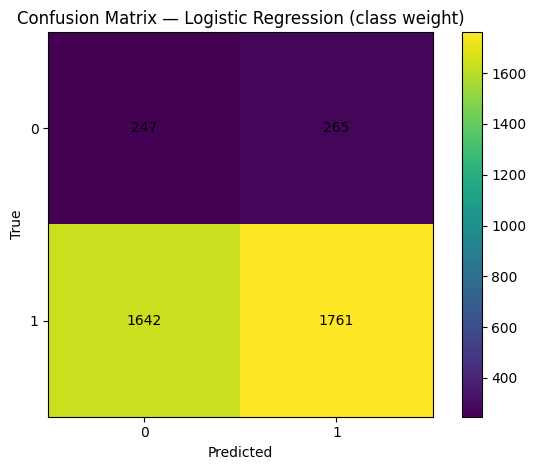

In [8]:
lr_weighted = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=2000, class_weight=cw, random_state=RANDOM_STATE))
])
lr_weighted.fit(X_train, y_train)

proba_lr = lr_weighted.predict_proba(X_test)[:,1]
pred_lr = (proba_lr >= THRESHOLD).astype(int)

print("F1 (pos):", f1_score(y_test, pred_lr))
print(classification_report(y_test, pred_lr, digits=4))

cm_lr = confusion_matrix(y_test, pred_lr)
plt.figure()
plt.imshow(cm_lr, interpolation="nearest")
plt.title("Confusion Matrix — Logistic Regression (class weight)")
plt.colorbar()
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_lr[i,j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## 6. Model 2: XGBoost (sample_weight dari class weight)

F1 (pos): 0.7101068488351725
              precision    recall  f1-score   support

           0     0.1448    0.4551    0.2197       512
           1     0.8790    0.5957    0.7101      3403

    accuracy                         0.5773      3915
   macro avg     0.5119    0.5254    0.4649      3915
weighted avg     0.7830    0.5773    0.6460      3915



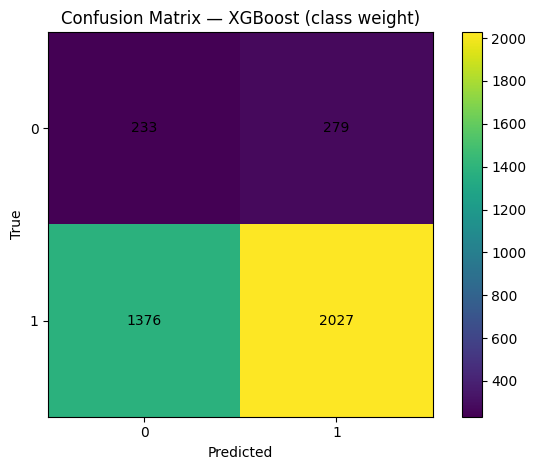

In [9]:
w_train = np.array([cw[int(label)] for label in y_train], dtype=float)

xgb_weighted = XGBClassifier(**XGB_PARAMS)
xgb_weighted.fit(X_train, y_train, sample_weight=w_train)

proba_xgb = xgb_weighted.predict_proba(X_test)[:,1]
pred_xgb = (proba_xgb >= THRESHOLD).astype(int)

print("F1 (pos):", f1_score(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb, digits=4))

cm_xgb = confusion_matrix(y_test, pred_xgb)
plt.figure()
plt.imshow(cm_xgb, interpolation="nearest")
plt.title("Confusion Matrix — XGBoost (class weight)")
plt.colorbar()
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["0","1"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_xgb[i,j], ha="center", va="center")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## 7. SMOTE (Opsional) + Pemilihan Model Terbaik

In [10]:
results = []

def eval_basic(name, y_true, proba):
    pred = (proba >= THRESHOLD).astype(int)
    return {
        "model": name,
        "accuracy": accuracy_score(y_true, pred),
        "precision_pos": precision_score(y_true, pred, pos_label=1, zero_division=0),
        "recall_pos": recall_score(y_true, pred, pos_label=1, zero_division=0),
        "f1_pos": f1_score(y_true, pred, pos_label=1, zero_division=0),
        "auc": roc_auc_score(y_true, proba),
    }

results.append(eval_basic("LogisticRegression_weighted", y_test, proba_lr))
results.append(eval_basic("XGBoost_weighted", y_test, proba_xgb))

if IMBLEARN_AVAILABLE:
    smote = SMOTE(random_state=RANDOM_STATE)

    lr_smote = ImbPipeline(steps=[
        ("smote", smote),
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=2000, random_state=RANDOM_STATE))
    ])
    lr_smote.fit(X_train, y_train)
    proba_lr_sm = lr_smote.predict_proba(X_test)[:,1]
    results.append(eval_basic("LogisticRegression_SMOTE", y_test, proba_lr_sm))

    xgb_smote = ImbPipeline(steps=[
        ("smote", smote),
        ("clf", XGBClassifier(**XGB_PARAMS))
    ])
    xgb_smote.fit(X_train, y_train)
    proba_xgb_sm = xgb_smote.predict_proba(X_test)[:,1]
    results.append(eval_basic("XGBoost_SMOTE", y_test, proba_xgb_sm))

results_df = pd.DataFrame(results).sort_values("f1_pos", ascending=False)
results_df


,model,accuracy,precision_pos,recall_pos,f1_pos,auc
1,XGBoost_weighted,0.577267,0.879011,0.595651,0.710107,0.520509
0,LogisticRegression_weighted,0.512899,0.869200,0.517485,0.648738,0.503048


## 8. ROC/PR Curve & Feature Importance (opsional)

Best model: XGBoost_weighted


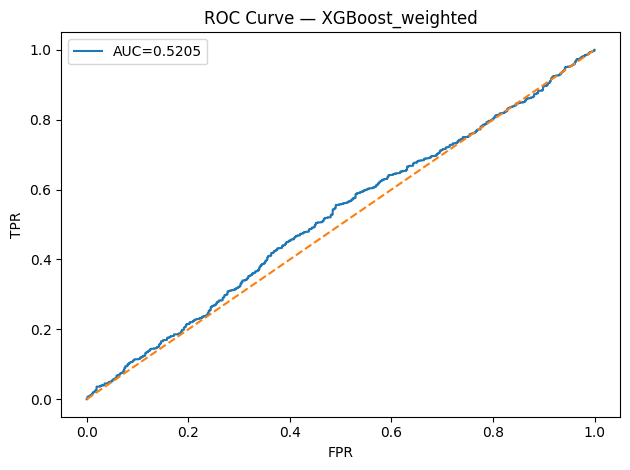

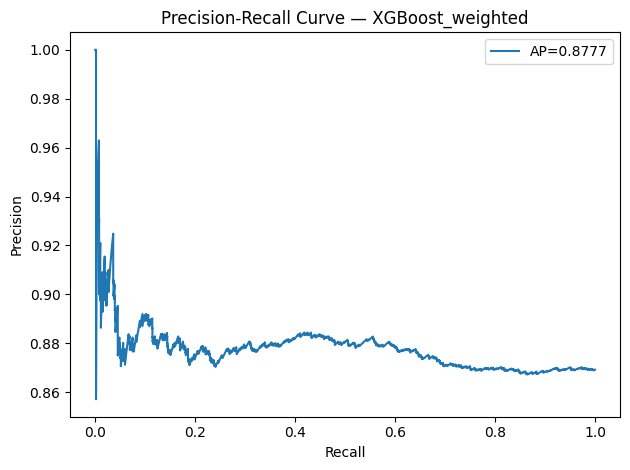

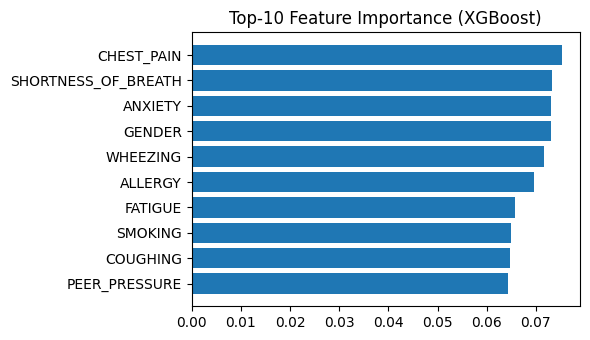

In [11]:
# Contoh ROC untuk model terbaik di results_df
best_name = results_df.iloc[0]["model"]
print("Best model:", best_name)

# Tentukan proba terbaik (contoh sederhana)
if best_name == "XGBoost_weighted":
    best_proba = proba_xgb
    best_est = xgb_weighted
elif best_name == "LogisticRegression_weighted":
    best_proba = proba_lr
    best_est = lr_weighted
elif best_name == "XGBoost_SMOTE":
    best_proba = proba_xgb_sm
    best_est = xgb_smote
else:
    best_proba = proba_lr_sm
    best_est = lr_smote

fpr, tpr, _ = roc_curve(y_test, best_proba)
auc = roc_auc_score(y_test, best_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
plt.plot([0,1],[0,1], linestyle="--")
plt.title(f"ROC Curve — {best_name}")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.tight_layout()
plt.show()

prec, rec, _ = precision_recall_curve(y_test, best_proba)
ap = average_precision_score(y_test, best_proba)
plt.figure()
plt.plot(rec, prec, label=f"AP={ap:.4f}")
plt.title(f"Precision-Recall Curve — {best_name}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.tight_layout()
plt.show()

# Feature importance jika model XGBoost
# jika pipeline imblearn -> ambil step clf
xgb_est = None
if isinstance(best_est, XGBClassifier):
    xgb_est = best_est
elif hasattr(best_est, "named_steps") and "clf" in best_est.named_steps:
    if isinstance(best_est.named_steps["clf"], XGBClassifier):
        xgb_est = best_est.named_steps["clf"]

if xgb_est is not None:
    imp = xgb_est.feature_importances_
    idx = np.argsort(imp)[::-1][:10]
    plt.figure(figsize=(6,3.5))
    plt.barh(list(reversed([FEATURES[i] for i in idx])), list(reversed(imp[idx])))
    plt.title("Top-10 Feature Importance (XGBoost)")
    plt.tight_layout()
    plt.show()


## 9. Simpan Model Terbaik

In [12]:
os.makedirs("models", exist_ok=True)

# Map estimator
model_map = {
    "LogisticRegression_weighted": lr_weighted,
    "XGBoost_weighted": xgb_weighted,
}
if IMBLEARN_AVAILABLE:
    model_map["LogisticRegression_SMOTE"] = lr_smote
    model_map["XGBoost_SMOTE"] = xgb_smote

best_estimator = model_map[best_name]
joblib.dump(best_estimator, "models/best_lung_cancer_model.joblib")
print("Saved: models/best_lung_cancer_model.joblib")


Saved: models/best_lung_cancer_model.joblib
